# 8- MÉTRICAS

Vamos ahora analizar en nuestro dataset diferentes metricas que resumiemos a continuacion en el siguinte cuadro:

![metricas](metricas.jpg)

En primer lugar cargamos las ibrerías y realizamos otros ajustes:

In [20]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import warnings
warnings. filterwarnings("ignore")
plt.style.use('bmh')

from nilmtk import TimeFrame, MeterGroup, HDFDataStore, DataSet
from nilmtk.metrics import fraction_energy_assigned_correctly, mean_normalized_error_power
from nilmtk.metrics import rms_error_power, f1_score, error_in_assigned_energy

data_dir='./data/'

### Métricas individuales del modelo

In [21]:
#Librerías
from nilmtk.metrics import f1_score
from nilmtk.metrics import error_in_assigned_energy
from nilmtk.metrics import mean_normalized_error_power
from nilmtk.metrics import rms_error_power
from nilmtk.metrics import fraction_energy_assigned_correctly

In [22]:

labels = pd.DataFrame({'Instances': list(range(1,7)),
                       'Meters': ['main',  'fan', 'freezer', 'television','vacuum cleaner', 'boiler']})


#Set para validación
valid = DataSet('dsual.h5')
valid.set_window(start="2022-02-02 12:00:00", end="2022-02-02 14:00:00")
valid_elec = valid.buildings[1].elec

print('\nDispositivos para validación de entrenamiento:')
valid_Devices = valid_elec.select(instance=[2,3,4,5,6])
print(valid_Devices)

#Datos de Dispositivos: predicción
dataset=DataSet(data_dir+'NILM/Results/CO_30s_first_pred.h5')
predictions=dataset.buildings[1].elec.submeters()    







index = list(labels['Meters'][1:6])
met = []
e = []
#Datos de Dispositivos: predicción
dataset=DataSet(data_dir+'NILM/Results/CO_60s_first_pred.h5')
predictions=dataset.buildings[1].elec.submeters()      

#Metricas
f1 = {}; eae = {}; feac = {}; mneap = {}; rmse = {};

f1['F1'] = f1_score(predictions, valid_Devices)

EAE = error_in_assigned_energy(predictions, valid_Devices)
for x in range(len(EAE)): e.append(EAE.iloc[x][0])
eae['EAE'] = e

#da error esta medida AttributeError: 'tuple' object has no attribute 'instance'
#feac['FEAC'] = np.ones(6)*(fraction_energy_assigned_correctly(predictions, valid_Devices))
#feac['FEAC'] = np.ones(6)*(fraction_energy_assigned_correctly(predictions, valid_Devices))


mneap['MNEAP'] = mean_normalized_error_power(predictions, valid_Devices)

rmse['RMSE'] = rms_error_power(predictions, valid_Devices)

met.append(pd.concat([pd.DataFrame(feac, index=valid_Devices.instance()),
                      pd.DataFrame(f1),
                      pd.DataFrame(eae, index=valid_Devices.instance()),
                      pd.DataFrame(mneap),
                      pd.DataFrame(rmse)],
                     axis=1).set_index(pd.Index(index)))

dataset.store.close()       
print('\n\nDone!')
metrics=met[0].transpose().round(3)
metrics


Dispositivos para validación de entrenamiento:
MeterGroup(meters=
  ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])
  ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='freezer', instance=1)])
  ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='television', instance=1)])
  ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='vacuum cleaner', instance=1)])
  ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='boiler', instance=1)])
)


Done!


,fan,freezer,television,vacuum cleaner,boiler
F1,0.760,0.698,0.588,0.943,0.000
EAE,0.000,0.000,0.000,0.000,0.000
MNEAP,0.512,0.633,0.411,0.123,1.000
RMSE,17.556,20.821,15.814,153.797,2.711


Carga de datos de predicciones y GT en memoria

In [28]:
gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=30, resample_kwargs={'how':'first'})

labels = pd.DataFrame({'Instances': list(range(1,7)),
                       'Meters': ['main',  'fan', 'freezer', 'television','vacuum cleaner', 'boiler']})

Meters={}
for x in range(len(labels)): Meters[valid_elec[x+1]]=labels['Meters'][x]
    

    
    
#resultados de predicción modelo CO 30s
CO_30s_first=DataSet(data_dir+'NILM/Results/CO_30s_first_pred.h5')
elec_CO_30s_first=CO_30s_first.buildings[1].elec

#resultados de predicción modelo FHMM 30s
FHMM_30s_first=DataSet(data_dir+'NILM/Results/FHMM_30s_first_pred.h5')
elec_FHMM_30s_first= FHMM_30s_first.buildings[1].elec    
    
    

gt.columns=list(Meters.values())
pred_CO=elec_CO_30s_first.dataframe_of_meters(ac_type='active')

pred_CO.columns=[list(Meters.values())[0]]+list(Meters.values())[1:6]

pred_FHMM=elec_FHMM_30s_first.dataframe_of_meters(ac_type='active')

pred_FHMM.columns=[list(Meters.values())[0]]+list(Meters.values())[1:6]

### Análisis particular del cálculo de cada métrica

Metrica FEAC ( da problema con AttributeError: 'tuple' object has no attribute 'instance')

In [29]:
#Carga de datos de predicciones y GT en memoria
#gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=60, resample_kwargs={'how':'first'})
#gt.columns=list(Meters.values())

In [30]:
#predictions_Devices=elec_CO_60s_first.submeters()

#frac_1 = valid_Devices.fraction_per_meter()
#frac_2 = predictions_Devices.fraction_per_meter()
#fig, (ax1, ax2) = plt.subplots(1, 2 ,gridspec_kw={'hspace': 0.1, 'wspace': 0.1})

#frac_1.plot(autopct=lambda p:'{:.0f}%'.format(p), kind='pie',labels=list(Meters.values())[1:6], figsize=(8,8), ax=ax1,   colors=['tab:blue','tab:orange','tab:green','tab:olive','tab:purple','tab:cyan'])
#frac_2.plot(autopct=lambda p:'{:.0f}%'.format(p), kind='pie',  labels=list(Meters.values())[1:6], figsize=(8,8), ax=ax2,  colors=['tab:blue','tab:orange','tab:green','tab:olive','tab:purple','tab:cyan']) 

#ax1.set(ylabel="")
#ax1.set(xlabel="GT")
#ax2.set(ylabel="")
#ax2.set(xlabel="Predictions")
#plt.savefig('./data/images/5.4_FEAC_CO_60s.svg', bbox_inches='tight', transparent=True)
#pass

## Métrica F1

In [31]:
pd.DataFrame(metrics.loc['F1']).transpose()*100

,fan,freezer,television,vacuum cleaner,boiler
F1,76.0,69.8,58.8,94.3,0.0


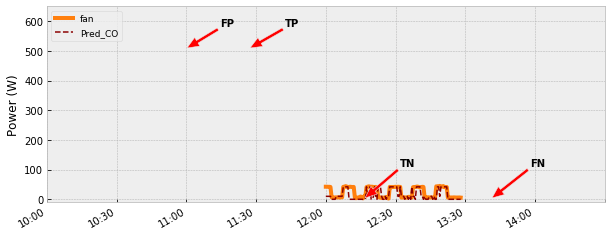

In [32]:
rcParams['figure.figsize'] = (10, 4)
t0='2022-02-02 10:00:00+01:00' #tiempo inicial
t1='2022-02-02 14:00:00+01:00' #tiempo final
fig, ax1 = plt.subplots();
ax1=gt['fan'].plot(lw=4, c='tab:orange')
pred_CO['fan'].plot(ax=ax1, c='darkred', lw=1.5, ls='--')
ax1.legend(labels=['fan','Pred_CO'], fontsize=9, loc='upper left', ncol=1)
ax1.set_ylim(-10,650)
ax1.set_xlim(t0,t1)
ax1.minorticks_off()
ax1.set_xticklabels(labels=['10:00','10:30','11:00','11:30','12:00','12:30','13:30','14:00']
                    , horizontalalignment ='right')  
ax1.set_ylabel('Power (W)')
ax1.annotate('TP', xy=(250, 188), xycoords='figure points', xytext=(285, 210), fontweight='bold',
             arrowprops=dict(facecolor='red', width=3, headwidth=10))
ax1.annotate('TN', xy=(365, 38), xycoords='figure points', xytext=(400, 70), fontweight='bold',
             arrowprops=dict(facecolor='red', width=3, headwidth=10))
ax1.annotate('FN', xy=(492, 38), xycoords='figure points', xytext=(530, 70), fontweight='bold',
             arrowprops=dict(facecolor='red', width=3, headwidth=10))
ax1.annotate('FP', xy=(187, 188), xycoords='figure points', xytext=(220, 210), fontweight='bold',
             arrowprops=dict(facecolor='red', width=3, headwidth=10))
plt.savefig('./data/images/5.5_F1_CO_60s.svg', bbox_inches='tight', transparent=True)
pass

## Métrica EAE

In [33]:
round(pd.DataFrame(metrics.loc['EAE']).transpose(),2)

,fan,freezer,television,vacuum cleaner,boiler
EAE,0.0,0.0,0.0,0.0,0.0


In [35]:
predictions_Devices=elec_CO_30s_first.submeters()
e1=predictions_Devices[5].total_energy()[0]
e2=valid_Devices[5].total_energy()[0]
eae=round(abs(e1-e2),2)

pd.DataFrame([e1,e2,eae], columns=['kWh'], index=['Energy_pred','Energy_GT','EAE'])

,kWh
Energy_pred,0.019103
Energy_GT,0.019103
EAE,0.000000


## Métrica MNEAP

In [34]:
round(pd.DataFrame(metrics.loc['MNEAP']).transpose(),2)

,fan,freezer,television,vacuum cleaner,boiler
MNEAP,0.57,0.81,0.42,0.12,1.0


TypeError: no numeric data to plot

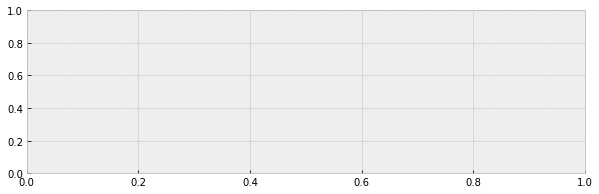

In [36]:
rcParams['figure.figsize'] = (10, 3)
fig, ax1 = plt.subplots();
a1=[1240,1250]
gt['fan'][a1[0]:a1[1]].plot(ax=ax1, lw=2, c='tab:purple', marker="D")

pred_CO['fan'][a1[0]:a1[1]].plot(ax=ax1, c='darkred', lw=1, ls='--', marker="D")

ax1.minorticks_off()
ax1.set_ylabel('Power (W)')
ax1.legend(labels=['GT fan','Pred_CO'], fontsize=9, ncol=1)

err= abs(round((gt['fan'][a1[0]:a1[1]]-pred_CO['fan'][a1[0]:a1[1]])[1:6],1))
aux=40
i=0
for e in err:
    ax1.annotate((str(err[i])+'W'), xy=(aux, 30+(abs(err[i]))*0.2), xycoords='axes points', size=10)
    aux=aux+63
    i=i+1

ax1.set_xticklabels(labels=['10:00','10:30','11:00','11:30','12:00','12:30','13:00','13:30','14:00',''])   
plt.savefig('./data/images/5.6_MNEAP_CO_30s.svg', bbox_inches='tight', transparent=True)
pass

## Métrica RMSE

In [37]:
round(pd.DataFrame(metrics.loc['RMSE']).transpose(),1)

,fan,freezer,television,vacuum cleaner,boiler
RMSE,17.6,20.8,15.8,153.8,2.7


In [38]:
from nilmtk.metrics import fraction_energy_assigned_correctly, f1_score, error_in_assigned_energy
from nilmtk.metrics import mean_normalized_error_power, rms_error_power 
periods = {'10s':10 , '30s':30, '60s':60, '5min':60*5, '10min':60*10, '15min':60*15, '30min':60*30}

dir_predictions = data_dir +'NILM/Results/'
m = {}
classifiers = ['CO', 'FHMM']
methods = ['first', 'mean', 'median']
index = list(labels['Meters'][1:6])

for p_name, sp in periods.items():
    met = []
    for method in methods:
        for clf_name in classifiers:
            print('\nCalculando Metricas: '+ clf_name + '_' + p_name + '_' + method)  
            #Datos de Dispositivos: predicción
            input_dir = dir_predictions + clf_name + '_' + p_name + '_' + method +'_pred.h5'
            dataset = DataSet(input_dir)
            predictions=dataset.buildings[1].elec.submeters()       
            #Metricas
            f1 = {}; eae = {}; feac = {}; mneap = {}; rmse = {}; e=[];  
            F1 = f1_score(predictions, valid_Devices)
            f1['F1'] = F1*100
            EAE = error_in_assigned_energy(predictions, valid_Devices)
            for x in range(len(EAE)): e.append(EAE.iloc[x][0])
            eae['EAE'] = e
            feac['FEAC'] = 100*np.ones(6)*(fraction_energy_assigned_correctly(predictions, valid_Devices))
            mneap['MNEAP'] = mean_normalized_error_power(predictions, valid_Devices)
            rmse['RMSE'] = rms_error_power(predictions, valid_Devices)
            met.append(pd.concat([pd.DataFrame(feac, index=valid_Devices.instance()),
                                  pd.DataFrame(f1),
                                  pd.DataFrame(eae, index=valid_Devices.instance()),
                                  pd.DataFrame(mneap),
                                  pd.DataFrame(rmse)],
                                 axis=1).set_index(pd.Index(index)))
            dataset.store.close()        
    m[p_name] = met
##Guarda resultados
f = open(data_dir +'NILM/metrics.txt',"w")
f.write( str(m) )
f.close()
print('\n\nDone!')
#m[0] #CO first #m[1] #FHMM first #m[2] #CO mean #m[3] #FHMM mean #m[4] #CO median #m[5] #FHMM median


Calculando Metricas: CO_10s_first
5/5 ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='boiler', instance=1)])nce=1)])

AttributeError: 'tuple' object has no attribute 'instance'

## Otras Metricas: métricas Promedio

In [39]:
m_mean = {}

cols=['FEAC','F1','EAE','MNEAP','RMSE']
labels=['CO-first', 'CO-mean', 'CO-median', 'FHMM-first', 'FHMM-mean' ,'FHMM-median']
per=['10s','30s','60s','5min','10min','15min','30min']

for c in cols:
    m_mean[c] = pd.DataFrame([#CO FIRST
                             [m['10s'][0][c].mean(),m['30s'][0][c].mean(),m['60s'][0][c].mean(),
                              m['5min'][0][c].mean(),m['10min'][0][c].mean(),
                              m['15min'][0][c].mean(),m['30min'][0][c].mean()],
                              #CO MEAN
                             [m['10s'][2][c].mean(),m['30s'][2][c].mean(),m['60s'][2][c].mean(),
                              m['5min'][2][c].mean(),m['10min'][2][c].mean(),
                              m['15min'][2][c].mean(),m['30min'][2][c].mean()],
                              #CO MEDIAN
                             [m['10s'][4][c].mean(),m['30s'][4][c].mean(),m['60s'][4][c].mean(),
                              m['5min'][4][c].mean(),m['10min'][4][c].mean(),
                              m['15min'][4][c].mean(),m['30min'][4][c].mean()],
                             #FHMM FIRST
                             [m['10s'][1][c].mean(),m['30s'][1][c].mean(),m['60s'][1][c].mean(),
                             m['5min'][1][c].mean(),m['10min'][1][c].mean(),
                              m['15min'][1][c].mean(),m['30min'][1][c].mean()],
                             #FHMM MEAN            
                             [m['10s'][3][c].mean(),m['30s'][3][c].mean(),m['60s'][3][c].mean(),
                              m['5min'][3][c].mean(),m['10min'][3][c].mean(),
                              m['15min'][3][c].mean(),m['30min'][3][c].mean()],
                             #FHMM MEDIAN
                             [m['10s'][5][c].mean(),m['30s'][5][c].mean(),m['60s'][5][c].mean(),
                              m['5min'][5][c].mean(),m['10min'][5][c].mean(),
                              m['15min'][5][c].mean(),m['30min'][5][c].mean()]],columns=per, index=labels).transpose()
m_mean

KeyError: '10s'

## Maximos


In [40]:
cols=['F1','EAE','MNEAP','RMSE']

maxs=pd.concat([m_mean['F1'].transpose().max(),
                m_mean['EAE'].transpose().min(),
                m_mean['MNEAP'].transpose().min(),
                m_mean['RMSE'].transpose().min()], axis=1)
maxs.columns=cols
maxs = maxs.transpose()
round(maxs,2)

KeyError: 'F1'

## Correspondencia de Indice

In [41]:
cols=['F1','EAE','MNEAP','RMSE']

maxs_i=pd.concat([m_mean['F1'].transpose().idxmax(),
                 m_mean['EAE'].transpose().idxmin(),
                 m_mean['MNEAP'].transpose().idxmin(),
                 m_mean['RMSE'].transpose().idxmin()], axis=1)
maxs_i.columns=cols
maxs_i = maxs_i.transpose()
maxs_i

KeyError: 'F1'

KeyError: 'FEAC'

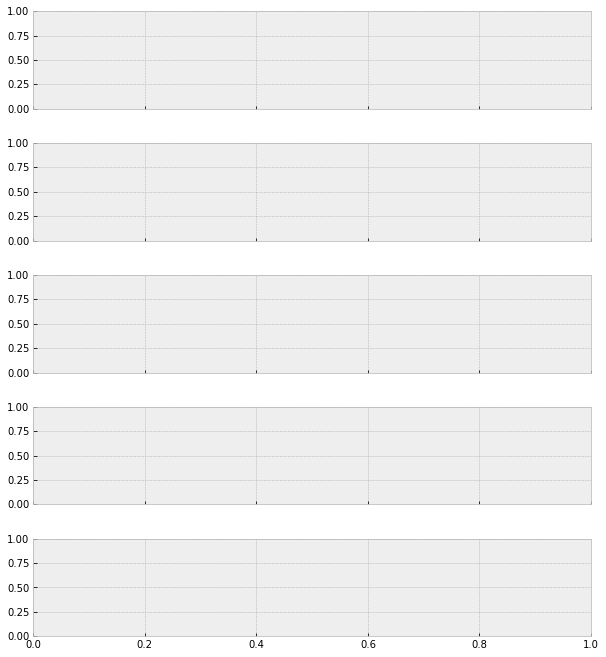

In [42]:
rcParams['figure.figsize'] = (10, 11.5)
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5, 1, sharex=True, gridspec_kw={'hspace': 0.35})
cols=['FEAC','F1','EAE','MNEAP','RMSE']
ylabels=['[%]','[%]','[kWh]','[-]','[W]']
per=['10s','30s','60s','5min','10min','15min','30min']

labels={'CO-first':-0.35, 'CO-mean':-0.22, 'CO-median':-0.11, 'FHMM-first':0.01, 'FHMM-mean':0.13 ,'FHMM-median':0.245}

c=0
for ax in fig.get_axes():      
    m_mean[cols[c]].plot.bar(ax=ax, width=0.7, edgecolor='black', linewidth=0.5, legend=False, cmap="jet")
    ax.set(ylabel=ylabels[c])
    ax.grid(b=None)
    x = 0
    for p in per:
        ax.annotate("▼", xy=(labels[maxs_i[p][cols[c]]]+x, maxs[p][cols[c]]+maxs[p][cols[c]]*0.03))
        x+=1
    c+=1
    
ax5.set_xticklabels(labels=per, rotation=0, fontdict={'fontsize':12})
fig.align_ylabels([(ax1,ax2,ax3,ax4,ax5)])
ax1.set(ylim=(0,120))
ax1.set_yticks([0,25,50,75,100])
ax2.set(ylim=(0,120))
ax2.set_yticks([0,25,50,75,100])
ax5.set_yticks([0,50,100,150,200])
ax1.set_title('Fraction of Energy Assigned Correctly - FEAC', fontsize=11, loc='center')
ax2.set_title('F1-Score', fontsize=11, loc='center')
ax3.set_title('Error in Assigned Energy - EAE', fontsize=11, loc='center')
ax4.set_title('Mean Normalised Error in Assigned Power - MNEAP', fontsize=11, loc='center')
ax5.set_title('RMS Error in Assigned Power - RMSE', fontsize=11, loc='center')
lgd = ax5.legend(labels.keys(), loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.6),fontsize=9.5)


ax1.annotate("97.1%", xy=(5.8, 100)); #30min FHMM-median
ax2.annotate("90.5%", xy=(0.68, 98)); #30s FHMM-mean
ax3.annotate("0.19", xy=(6.22, 1.4)); #30min FHMM-median
ax3.annotate("kWh", xy=(6.22, 0.9)); #30min FHMM-median
ax4.annotate("0.24", xy=(6.22, 0.7)); #30min FHMM-median
ax5.annotate("41.5", xy=(6.22, 120)); #30min FHMM-median
ax5.annotate("   W", xy=(6.22, 90)); #30min FHMM-median


plt.savefig('./data/images/5.7_All_metrics.svg', bbox_inches='tight', transparent=True)

pass

In [ ]:
rcParams['figure.figsize'] = (10, 8)

fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5, 1, sharex=False, gridspec_kw={'hspace': 0.35})
cols=['FEAC','F1','EAE','MNEAP','RMSE']
ylabels=['[%]','[%]','[kWh]','[-]','[W]']
labels=['FHMM-first', 'FHMM-mean' ,'FHMM-median']
c=0

for ax in fig.get_axes():
    
    df=pd.DataFrame([m['30min'][1][cols[c]],m['30min'][3][cols[c]],m['30min'][5][cols[c]]]).transpose()
    if ax==ax1:
        df['FEAC'].mean().plot.barh(ax=ax1, width=0.7, edgecolor='black', linewidth=0.5, legend=False,
                                    color=['greenyellow','darkorange','maroon'])
    else:
        df.plot.bar(ax=ax, width=0.7, edgecolor='black', linewidth=0.5, legend=False,
                    color=['greenyellow','darkorange','maroon'])
    ax.set(ylabel=ylabels[c])
    ax.grid(b=None)
    c+=1   
    
ax1.set_xticklabels(['0','','','','','100'])
ax1.set_yticklabels('')
ax2.set_xticklabels('')
ax3.set_xticklabels('')
ax4.set_xticklabels('')
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=0, fontdict={'fontsize':12})
fig.align_ylabels([(ax1,ax2,ax3,ax4,ax5)])
ax1.set(xlim=(0,108))
ax2.set(ylim=(0,120))
ax3.set_yticks([0,1,2,3,4])
ax4.set(ylim=(0,1.8))
ax4.set_yticks([0,0.5,1,1.5,2])
ax5.set(ylim=(0,270))
ax5.set_yticks([0,100,200,300])
ax1.set_title('Fraction of Energy Assigned Correctly - FEAC', fontsize=11, loc='center')
ax2.set_title('F1-Score', fontsize=11, loc='center')
ax3.set_title('Error in Assigned Energy - EAE', fontsize=11, loc='center')
ax4.set_title('Mean Normalised Error in Assigned Power - MNEAP', fontsize=11, loc='center')
ax5.set_title('RMS Error in Assigned Power - RMSE', fontsize=11, loc='center')
lgd = ax5.legend(labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.8))

ax1.annotate("◄ 97.1%", xy=(98, 1.9))

plt.savefig('./data/images/5.8_All_metrics_2.svg', bbox_inches='tight', transparent=True)

pass

In [43]:
print('FHMM-first')
print(m['30min'][1])
print('\nFHMM-mean')
print(m['30min'][3])
print('\nFHMM-median')
print(m['30min'][5])

FHMM-first


KeyError: '30min'

### Resultados del mejor modelo
En vista de los resultados del obtenidos, se propone la elección del modelo FHMM entrenado con datos promedio de dispositivos cada 10 minutos. Este modelo solo se considera adecuado para la desagregación de datos promedio de potencia activa medidos en cabecera cada 10 minutos.

KeyError: '30min'

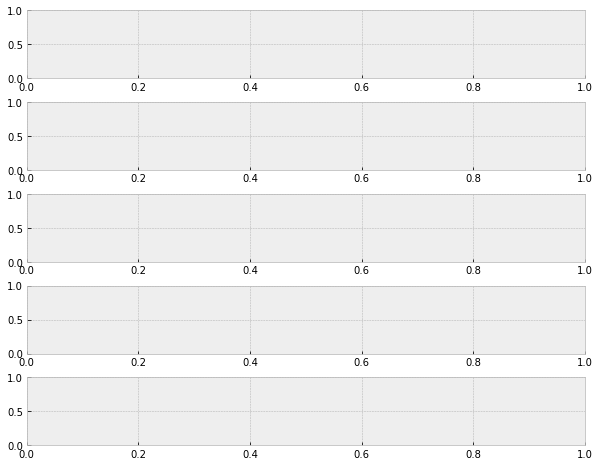

In [44]:
rcParams['figure.figsize'] = (10, 8)

fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5, 1, sharex=False, gridspec_kw={'hspace': 0.35})
cols=['FEAC','F1','EAE','MNEAP','RMSE']
ylabels=['[%]','[%]','[kWh]','[-]','[W]']
colors=['tab:red','tab:blue','tab:orange','tab:green','tab:olive','tab:purple','tab:cyan']
c=0

for ax in fig.get_axes():
    df=pd.DataFrame(m['30min'][5][cols[c]])
    if ax==ax1:
        pass
        df.mean().plot.barh(ax=ax1, width=0.7, edgecolor='black', linewidth=0.5, legend=False, color='gold')
    else:
        df[cols[c]].plot.bar(ax=ax, width=0.7, edgecolor='black', linewidth=0.5, legend=False, color=colors)
    ax.set(ylabel=ylabels[c])
    ax.grid(b=None)
    c+=1

ax1.set_xticklabels(['0','','','','','100'])
ax1.set_yticklabels('')
ax2.set_xticklabels('')
ax3.set_xticklabels('')
ax4.set_xticklabels('')
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=0, fontdict={'fontsize':12})
fig.align_ylabels([(ax1,ax2,ax3,ax4,ax5)])
ax1.set(xlim=(0,105))
ax2.set(ylim=(0,125))
ax3.set(ylim=(0,1))
ax4.set(ylim=(0,0.7))
ax5.set(ylim=(0,110))

#ax2.set_yticks([0,25,50,75,100])
#ax3.set_yticks([0,1,2,3])
#ax4.set_yticks([0,1,2,3,4])
#ax5.set_yticks([0,50,100,150,200])

ax1.set_title('Fraction of Energy Assigned Correctly - FEAC', fontsize=11, loc='center')
ax2.set_title('F1-Score', fontsize=11, loc='center')
ax3.set_title('Error in Assigned Energy - EAE', fontsize=11, loc='center')
ax4.set_title('Mean Normalised Error in Assigned Power - MNEAP', fontsize=11, loc='center')
ax5.set_title('RMS Error in Assigned Power - RMSE', fontsize=11, loc='center')

df=pd.DataFrame(m['30min'][5])
ax1.annotate(str(round(df['FEAC'][3],1))+'%', xy=(df['FEAC'][0]+1 , 0.01), fontsize=9.5)
for x in range(6):ax2.annotate(str(round(df['F1'][x],1))+'%', xy=(x-0.18 , df['F1'][x]+4),fontsize=9.5)
for x in range(6):ax3.annotate(str(round(df['EAE'][x],1))+' kWh', xy=(x-0.25 , df['EAE'][x]+0.1),fontsize=9.5)
for x in range(6):ax4.annotate(str(round(df['MNEAP'][x],1)), xy=(x-0.08 , df['MNEAP'][x]+0.03),fontsize=9.5)
for x in range(6):ax5.annotate(str(round(df['RMSE'][x]))+' W', xy=(x-0.18 , df['RMSE'][x]+5),fontsize=9.5)

plt.savefig('./data/images/5.9_Metrics_FHMM_30min_median.svg', bbox_inches='tight', transparent=True)

In [45]:
valid_Devices.total_energy()

Calculating total_energy for ElecMeterID(instance=6, building=1, dataset='DSUAL') ...   

reactive     0.024328
active       0.440416
apparent    15.427855
dtype: float64

In [46]:
valid_Devices.energy_per_meter()

5/5 ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='boiler', instance=1)])nce=1)])

,"(2, 1, DSUAL)","(3, 1, DSUAL)","(4, 1, DSUAL)","(5, 1, DSUAL)","(6, 1, DSUAL)"
active,0.022232,0.016073,0.019346,0.380146,0.002619
apparent,NaN,NaN,NaN,NaN,NaN
reactive,NaN,NaN,NaN,NaN,NaN


### Replicando el entrenamiento del modelo

In [47]:
from nilmtk import DataSet
from nilmtk.legacy.disaggregate import FHMM


train = DataSet('dsual.h5')

train.set_window(start="2022-02-02 00:00:00", end="2022-02-03 23:59:59")
train_elec=train.buildings[1].elec 

#dispositivos a entrenar: [Lights_1, Lights_2, HVAC_1, HVAC_2, HVAC_4, Rack]
train_Devices=train_elec.select(instance=[2,3,4,5,6])

#opcional: asignación manual de estados de dispositivos
num_states={train_Devices[2]:2, train_Devices[3]:3, train_Devices[4]:4,
            train_Devices[5]:5, train_Devices[6]:6}

#entrenamiento y exportación del modelo
FHMM_30min_median=FHMM()
FHMM_30min_median.MIN_CHUNK_LENGTH=1
FHMM_30min_median.train(train_Devices,
                        num_states_dict={}, #en otro caso: { }
                        ac_type='active',
                        sample_period=1800,
                        resample_kwargs={'how':'median'})

FHMM_30min_median.export_model('./data/FHMM_30min_median_model.pickle') 

Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])' with 1 states
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='freezer', instance=1)])' with 1 states
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='television', instance=1)])' with 1 states
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='vacuum cleaner', instance=1)])' with 1 states
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='boiler', instance=1)])' with 1 states


AttributeError: Can't pickle local object 'WeakValueDictionary.__init__.<locals>.remove'

In [ ]:
Examinamos el modelo

In [ ]:
from nilmtk.legacy.disaggregate import FHMM
FHMM=FHMM()
FHMM.import_model('C:/data/FHMM_30min_median_model.pickle') 
print(type(FHMM.individual[valid_Devices[5]].means_))
print('Lights_1: '+str(FHMM.individual[valid_Devices[5]].means_))
print('Lights_1: '+str(FHMM.individual[valid_Devices[6]].means_))
print('HVAC_1: '+str(FHMM.individual[valid_Devices[7]].means_))
print('HVAC_2: '+str(FHMM.individual[valid_Devices[8]].means_))
print('HVAC_4: '+str(FHMM.individual[valid_Devices[9]].means_))
print('Rack: '+str(FHMM.individual[valid_Devices[10]].means_))